In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os


In [4]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Define your data path
data_path = '/content/drive/MyDrive/mango_dataset_demo/mango_datasets'

In [6]:
# Define parameters
input_shape = (224, 224, 3)
num_classes = 10
batch_size = 32
epochs = 10


In [7]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

In [8]:
# Load and augment the data
datagen = train_datagen.flow_from_directory(
    data_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical')

Found 3407 images belonging to 10 classes.


In [11]:
# Split the data into training, validation, and testing sets
total_samples = len(datagen.filenames)
train_samples = int(0.7 * total_samples)
valid_samples = int(0.2 * total_samples)
test_samples = total_samples - train_samples - valid_samples

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=input_shape[:2],
    batch_size=batch_size)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=input_shape[:2],
    batch_size=batch_size)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=input_shape[:2],
    batch_size=batch_size)

Found 3407 files belonging to 10 classes.
Using 2385 files for training.
Found 3407 files belonging to 10 classes.
Using 1022 files for validation.
Found 3407 files belonging to 10 classes.
Using 1022 files for validation.


In [43]:
# Retrieve the class names
class_names = list(datagen.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['Amropolli', 'Asina', 'Fajli', 'Funia', 'Gulabkhas', 'Gutthi', 'Khirsapoti', 'Langra', 'Lokhna', 'Totapuri']


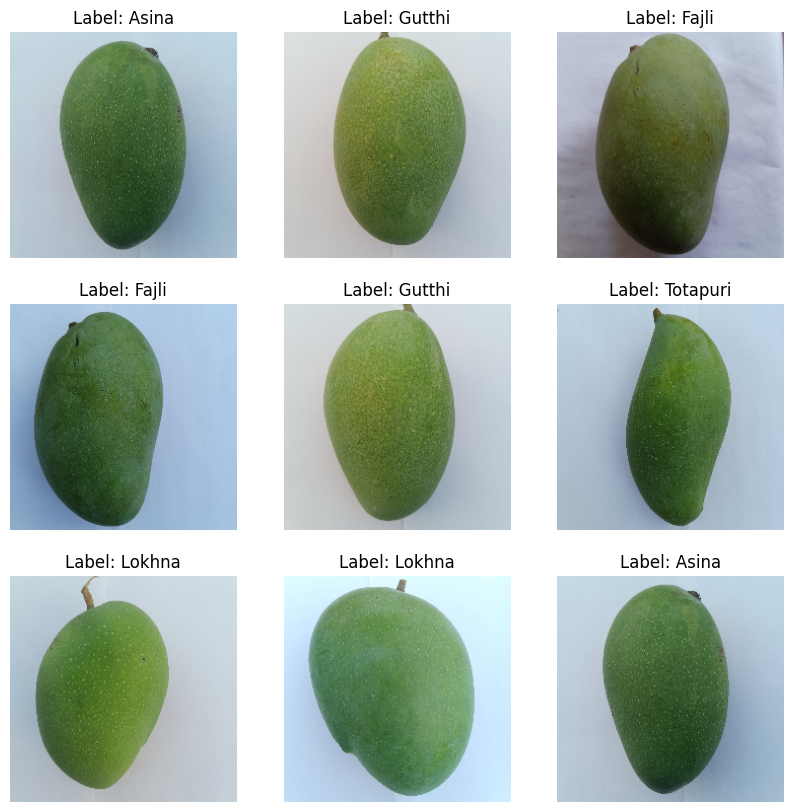

In [87]:
# Data Visualization
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    image_batch = images.numpy()
    labels_batch = labels.numpy()

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].astype("uint8"))
        plt.title("Label: " + class_names[np.argmax(labels_batch[i])])
        plt.axis("off")
plt.show()

In [68]:

# Load the pre-trained model
# base_model = tf.keras.applications.MobileNetV2(
#     input_shape=input_shape,
#     include_top=False,
#     weights='imagenet')
from keras.applications.vgg16 import VGG16
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

58889256/58889256 [==============================] - 4s 0us/step


In [76]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [77]:
# Create the model
from keras import Sequential
from keras.layers import Dense,Flatten
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(10,activation='softmax'))

In [78]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 21,140,042
Trainable params: 6,425,354
Non-trainable params: 14,714,688
_________________________________________________________________


In [74]:
# Freeze the base model
conv_base.trainable = False

In [79]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
# Train the model
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10)

Epoch 1/10
75/75 [==============================] - 128s 2s/step - loss: 8.3407 - accuracy: 0.8570 - val_loss: 0.0650 - val_accuracy: 0.9932
Epoch 2/10
75/75 [==============================] - 117s 1s/step - loss: 0.1113 - accuracy: 0.9887 - val_loss: 0.0147 - val_accuracy: 0.9971
Epoch 3/10
75/75 [==============================] - 123s 2s/step - loss: 0.0167 - accuracy: 0.9971 - val_loss: 0.0083 - val_accuracy: 0.9971
Epoch 4/10
75/75 [==============================] - 122s 2s/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.0027 - val_accuracy: 0.9980
Epoch 5/10
75/75 [==============================] - 118s 1s/step - loss: 0.1232 - accuracy: 0.9920 - val_loss: 0.6946 - val_accuracy: 0.9726
Epoch 6/10
75/75 [==============================] - 118s 1s/step - loss: 0.1785 - accuracy: 0.9904 - val_loss: 0.5483 - val_accuracy: 0.9697
Epoch 7/10
75/75 [==============================] - 119s 1s/step - loss: 0.1063 - accuracy: 0.9950 - val_loss: 0.0294 - val_accuracy: 0.9990
Epoch 8/10
75

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

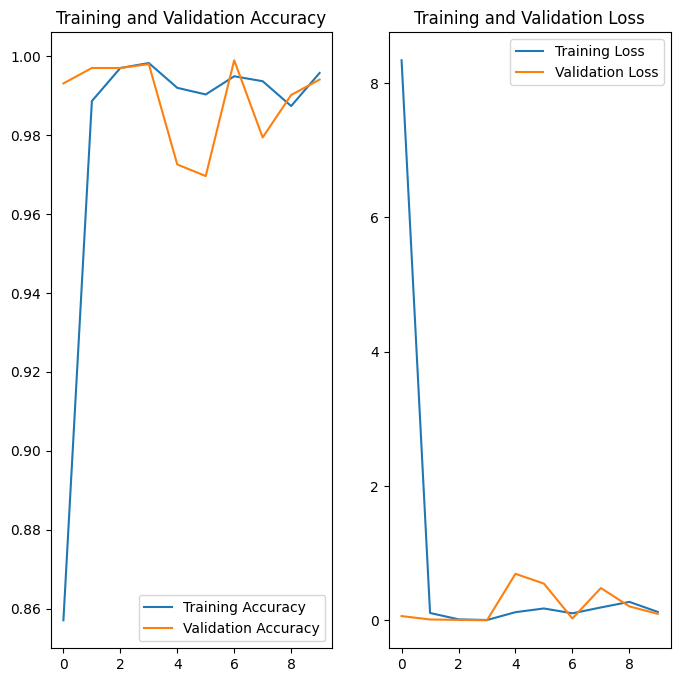

In [83]:
EPOCHS = 10
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 159ms/step
Classification Report:
              precision    recall  f1-score   support

   Amropolli       1.00      0.97      0.99       103
       Asina       1.00      0.99      1.00       109
       Fajli       1.00      1.00      1.00       103
       Funia       1.00      1.00      1.00       106
   Gulabkhas       0.98      1.00      0.99       105
      Gutthi       1.00      1.00      1.00       110
  Khirsapoti       1.00      0.98      0.99       100
      Langra       0.99      1.00      1.00       102
      Lokhna       0.97      1.00      0.99       106
    Totapuri       1.00      1.00      1.00        78

    accuracy                           0.99      1022
   macro avg       0.99      0.99      0.99      1022
weighted avg       0.99      0.99      0.99      1022

Confusion Matrix:


<Axes: >

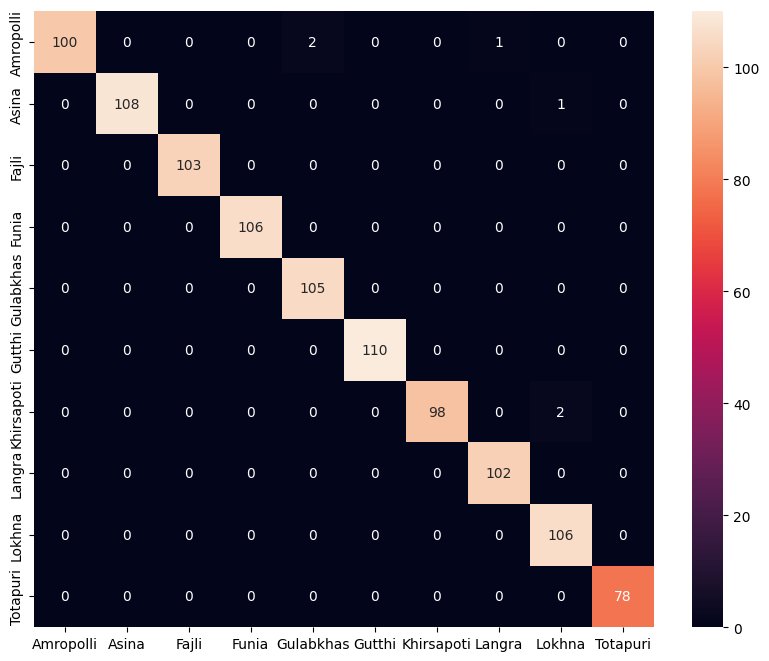

In [84]:
import seaborn as sns

# Calculate classification and confusion matrix
test_labels = []
test_predictions = []
for images, labels in test_data:
    predictions = model.predict(images)
    test_labels.extend(np.argmax(labels, axis=1))
    test_predictions.extend(np.argmax(predictions, axis=1))

# Classification report
print('Classification Report:')
print(classification_report(test_labels, test_predictions, target_names=class_names))

# Confusion matrix
print('Confusion Matrix:')
cm = confusion_matrix(test_labels, test_predictions)
# print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_names,yticklabels=class_names)
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.show()


In [89]:
def predict(model, img):
    img_array = tensorflow.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tensorflow.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


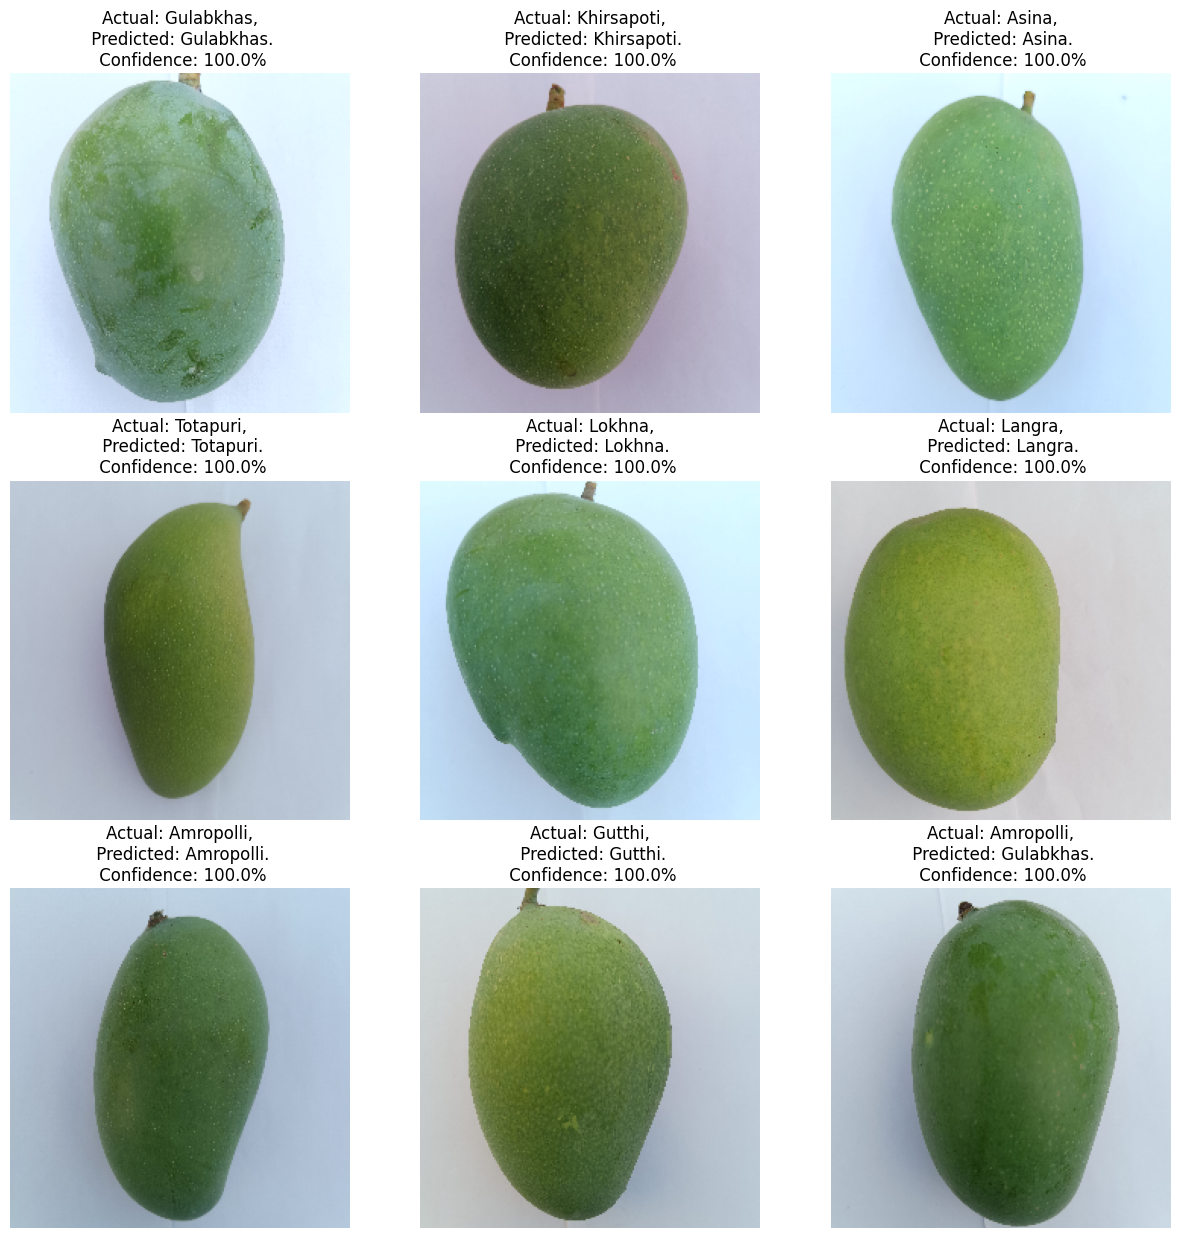

In [92]:
import tensorflow
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[np.argmax(labels[i])]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [91]:

# Save the model
model.save('mango_classification_model.h5')

In [86]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/mango_dataset_demo/models") + [0]])+1
model.save(f"/content/drive/MyDrive/mango_dataset_demo/models/{model_version}")